# 1. Exploring data for modeling phase 

In [ ]:
# pip install seaborn 
#! pip install -U imbalanced-learn
#! pip install xgboost

In [30]:
import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier  # Using XGBoost instead of RandomForest

import time



In [3]:
df_lct_dl = pd.read_csv('../data/raw/curr_lct_dl.csv')

In [4]:
df_lct_dl

,unit_id,ddate,dtime,target,address,packets_received,packets_sent,packet_size,bytes_total,duration,bytes_sec,error_code,successes,failures
0,386,2023-02-01,2023-02-02 00:50:49,sp1-vm-newyork-us.samknows.com,151.139.31.1,52,100,1400,72800,993,87311824,NO_ERROR,1,0
1,386,2023-02-02,2023-02-02 11:47:29,sp1-vm-newyork-us.samknows.com,151.139.31.1,52,100,1400,72800,765,87866112,NO_ERROR,1,0
2,386,2023-02-02,2023-02-02 17:47:06,sp1-vm-newyork-us.samknows.com,151.139.31.1,79,100,1400,110600,6292,69421488,NO_ERROR,1,0
3,386,2023-02-03,2023-02-03 05:50:56,sp1-vm-newyork-us.samknows.com,151.139.31.1,81,100,1400,113400,6653,44712440,NO_ERROR,1,0
4,386,2023-02-03,2023-02-04 00:51:20,sp1-vm-newyork-us.samknows.com,151.139.31.1,79,100,1400,110600,6278,80396040,NO_ERROR,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869696,93007349,2023-02-27,2023-02-28 05:51:32,sp1-vm-losangeles-us.samknows.com,151.139.71.29,100,100,1400,140000,6079,50450040,NO_ERROR,1,0
869697,93007349,2023-02-27,2023-02-28 06:49:38,sp1-vm-losangeles-us.samknows.com,151.139.71.29,100,100,1400,140000,3923,68643216,NO_ERROR,1,0
869698,93007349,2023-02-28,2023-02-28 08:44:37,sp1-vm-losangeles-us.samknows.com,151.139.71.29,100,100,1400,140000,2861,72056552,NO_ERROR,1,0
869699,93007349,2023-02-28,2023-02-28 14:45:22,sp1-vm-losangeles-us.samknows.com,151.139.71.29,100,100,1400,140000,2133,70877720,NO_ERROR,1,0


In [5]:
df_lct_dl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869701 entries, 0 to 869700
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   unit_id           869701 non-null  int64 
 1   ddate             869701 non-null  object
 2   dtime             869701 non-null  object
 3   target            869701 non-null  object
 4   address           869701 non-null  object
 5   packets_received  869701 non-null  int64 
 6   packets_sent      869701 non-null  int64 
 7   packet_size       869701 non-null  int64 
 8   bytes_total       869701 non-null  int64 
 9   duration          869701 non-null  int64 
 10  bytes_sec         869701 non-null  int64 
 11  error_code        869701 non-null  object
 12  successes         869701 non-null  int64 
 13  failures          869701 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 92.9+ MB


In [6]:
df_lct_dl['error_code'].unique()

array(['NO_ERROR', 'TCP_CONNECT', 'RCV_FAILED', 'ZERO_SENT_SERVER',
       'TCP_RECV'], dtype=object)

In [7]:
error_code_distribution = df_lct_dl['error_code'].value_counts()
print(error_code_distribution)

error_code
NO_ERROR            866807
TCP_CONNECT           2336
ZERO_SENT_SERVER       382
RCV_FAILED             175
TCP_RECV                 1
Name: count, dtype: int64


In [8]:
df_lct_dl.describe()

,unit_id,packets_received,packets_sent,packet_size,bytes_total,duration,bytes_sec,successes,failures
count,8.697010e+05,869701.000000,869701.000000,869701.0,869701.000000,8.697010e+05,8.697010e+05,869701.000000,869701.000000
mean,2.240975e+07,86.665430,99.667242,1400.0,121331.601780,3.357469e+04,3.121015e+07,0.996672,0.003328
std,2.541703e+07,20.926162,5.758916,0.0,29296.626978,1.075456e+05,3.590050e+07,0.057589,0.057589
min,3.860000e+02,0.000000,0.000000,1400.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.058040e+05,77.000000,100.000000,1400.0,107800.000000,5.606000e+03,4.770858e+06,1.000000,0.000000
50%,4.172669e+06,100.000000,100.000000,1400.0,140000.000000,9.491000e+03,1.371387e+07,1.000000,0.000000
75%,3.948602e+07,100.000000,100.000000,1400.0,140000.000000,2.381700e+04,4.576806e+07,1.000000,0.000000
max,9.300735e+07,100.000000,100.000000,1400.0,140000.000000,3.004544e+06,3.248000e+08,1.000000,1.000000


In [9]:
df_lct_dl[['bytes_sec', 'duration', 'packets_received', 'packets_sent']].describe()

,bytes_sec,duration,packets_received,packets_sent
count,8.697010e+05,8.697010e+05,869701.000000,869701.000000
mean,3.121015e+07,3.357469e+04,86.665430,99.667242
std,3.590050e+07,1.075456e+05,20.926162,5.758916
min,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,4.770858e+06,5.606000e+03,77.000000,100.000000
50%,1.371387e+07,9.491000e+03,100.000000,100.000000
75%,4.576806e+07,2.381700e+04,100.000000,100.000000
max,3.248000e+08,3.004544e+06,100.000000,100.000000


In [10]:
df_lct_dl.duplicated().value_counts()

False    869455
True        246
Name: count, dtype: int64

In [11]:
df_lct_dl.isnull().sum()

unit_id             0
ddate               0
dtime               0
target              0
address             0
packets_received    0
packets_sent        0
packet_size         0
bytes_total         0
duration            0
bytes_sec           0
error_code          0
successes           0
failures            0
dtype: int64

## Error Code Distribution

- **NO_ERROR**: 866,807 (99.7%)

- **TCP_CONNECT**: 2,336 (0.27%)

- **ZERO_SENT_SERVER**: 382 (0.04%)

- **RCV_FAILED**: 175 (0.02%)

- **TCP_RECV**: 1 (extremely rare)

## Data Characteristics

- **Missing Values**: None

- **Duplicate Rows**: 246 (can be removed)

- **Class Imbalance**: Extremely imbalanced classes (NO_ERROR dominates)

## Numerical Features

- **Variation**: Numerical features exhibit good variation.

- **Predictive Potential**: `bytes_sec` shows high variability and could be highly predictive.

# 2. Data Preprocessing

## remove duplicates

In [12]:
# remove the duplication 
df_cleaned = df_lct_dl.drop_duplicates().reset_index(drop=True)

In [13]:
df_cleaned

,unit_id,ddate,dtime,target,address,packets_received,packets_sent,packet_size,bytes_total,duration,bytes_sec,error_code,successes,failures
0,386,2023-02-01,2023-02-02 00:50:49,sp1-vm-newyork-us.samknows.com,151.139.31.1,52,100,1400,72800,993,87311824,NO_ERROR,1,0
1,386,2023-02-02,2023-02-02 11:47:29,sp1-vm-newyork-us.samknows.com,151.139.31.1,52,100,1400,72800,765,87866112,NO_ERROR,1,0
2,386,2023-02-02,2023-02-02 17:47:06,sp1-vm-newyork-us.samknows.com,151.139.31.1,79,100,1400,110600,6292,69421488,NO_ERROR,1,0
3,386,2023-02-03,2023-02-03 05:50:56,sp1-vm-newyork-us.samknows.com,151.139.31.1,81,100,1400,113400,6653,44712440,NO_ERROR,1,0
4,386,2023-02-03,2023-02-04 00:51:20,sp1-vm-newyork-us.samknows.com,151.139.31.1,79,100,1400,110600,6278,80396040,NO_ERROR,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869450,93007349,2023-02-27,2023-02-28 05:51:32,sp1-vm-losangeles-us.samknows.com,151.139.71.29,100,100,1400,140000,6079,50450040,NO_ERROR,1,0
869451,93007349,2023-02-27,2023-02-28 06:49:38,sp1-vm-losangeles-us.samknows.com,151.139.71.29,100,100,1400,140000,3923,68643216,NO_ERROR,1,0
869452,93007349,2023-02-28,2023-02-28 08:44:37,sp1-vm-losangeles-us.samknows.com,151.139.71.29,100,100,1400,140000,2861,72056552,NO_ERROR,1,0
869453,93007349,2023-02-28,2023-02-28 14:45:22,sp1-vm-losangeles-us.samknows.com,151.139.71.29,100,100,1400,140000,2133,70877720,NO_ERROR,1,0


## extract  features from date and time

In [14]:
df_cleaned['ddate'] = pd.to_datetime(df_cleaned['ddate'])
df_cleaned['dtime'] = pd.to_datetime(df_cleaned['dtime'])
df_cleaned['hour'] = df_cleaned['dtime'].dt.hour
df_cleaned['day_of_week'] = df_cleaned['ddate'].dt.dayofweek
df_cleaned['month'] = df_cleaned['ddate'].dt.month

In [15]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869455 entries, 0 to 869454
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   unit_id           869455 non-null  int64         
 1   ddate             869455 non-null  datetime64[ns]
 2   dtime             869455 non-null  datetime64[ns]
 3   target            869455 non-null  object        
 4   address           869455 non-null  object        
 5   packets_received  869455 non-null  int64         
 6   packets_sent      869455 non-null  int64         
 7   packet_size       869455 non-null  int64         
 8   bytes_total       869455 non-null  int64         
 9   duration          869455 non-null  int64         
 10  bytes_sec         869455 non-null  int64         
 11  error_code        869455 non-null  object        
 12  successes         869455 non-null  int64         
 13  failures          869455 non-null  int64         
 14  hour

## new feauture engineering part 

In [16]:
df_cleaned['packets_ratio'] = df_cleaned['packets_received'] / (df_cleaned['packets_sent'] + 1)  # Adding 1 to avoid division by zero
df_cleaned['transfer_efficiency'] = df_cleaned['bytes_sec'] / (df_cleaned['bytes_total'] + 1)  # Higher is better

# 3. Feature Selection

In [17]:
features = [
    'unit_id',                # Unit identifier
    'target',                 # Target server 
    'address',                # IP address
    'packets_received',       # Network performance metric
    'packets_sent',           # Network performance metric
    'packet_size',            # Size of packets
    'bytes_total',            # Total bytes transferred
    'duration',               # Duration of test
    'bytes_sec',              # Throughput
    'successes',              # Success count
    'failures',               # Failure count
    'hour',                   # Time feature
    'day_of_week',            # Day feature
    'month',                  # Month feature
    'packets_ratio',          # Engineered feature
    'transfer_efficiency'     # Engineered feature
]

## separate categorical and numerical features

In [18]:
# Separate categorical and numerical features
categorical_features = ['unit_id', 'target', 'address']   # unit_id as categorical to reducae the dimentionality we will process with it 
numerical_features = [f for f in features if f not in categorical_features]

In [19]:
print("Original class distribution:")
print(df_cleaned['error_code'].value_counts())

Original class distribution:
error_code
NO_ERROR            866564
TCP_CONNECT           2333
ZERO_SENT_SERVER       382
RCV_FAILED             175
TCP_RECV                 1
Name: count, dtype: int64


    -- Combine the rare class with another similar class to handle the rare class problem 

In [20]:
df_filtered = df_cleaned.copy()
# Map TCP_RECV to RCV_FAILED since they seem related
df_filtered.loc[df_filtered['error_code'] == 'TCP_RECV', 'error_code'] = 'RCV_FAILED'

In [21]:
print("\nModified class distribution:")
print(df_filtered['error_code'].value_counts())


Modified class distribution:
error_code
NO_ERROR            866564
TCP_CONNECT           2333
ZERO_SENT_SERVER       382
RCV_FAILED             176
Name: count, dtype: int64


In [22]:
X = df_filtered[features]
y = df_filtered['error_code']

In [ ]:
# 3. Apply label encoding to convert string labels to numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Store the mapping for later reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nLabel mapping:")
for class_name, encoded_value in label_mapping.items():
    print(f"{class_name} -> {encoded_value}")


Label mapping:
NO_ERROR -> 0
RCV_FAILED -> 1
TCP_CONNECT -> 2
ZERO_SENT_SERVER -> 3


# 4. Data Splitting

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [25]:
# Check class distribution in train and test sets
print("\nTraining set class distribution:")
train_dist = pd.Series(y_train).value_counts()
for code, count in train_dist.items():
    class_name = label_encoder.inverse_transform([code])[0]  # Convert back to original label
    print(f"{class_name} ({code}): {count}")


Training set class distribution:
NO_ERROR (0): 693286
TCP_CONNECT (2): 1830
ZERO_SENT_SERVER (3): 310
RCV_FAILED (1): 138


In [26]:
print("\nTest set class distribution:")
test_dist = pd.Series(y_test).value_counts()
for code, count in test_dist.items():
    class_name = label_encoder.inverse_transform([code])[0]  # Convert back to original label
    print(f"{class_name} ({code}): {count}")


Test set class distribution:
NO_ERROR (0): 173278
TCP_CONNECT (2): 503
ZERO_SENT_SERVER (3): 72
RCV_FAILED (1): 38


# 5. Create a preprocessing pipeline

In [27]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# 6. Build the pipeline with baseline model as RandomForest and class_weight

In [28]:
# 6. Build the pipeline with XGBoost
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100,         # Fewer trees for faster training
        max_depth=8,              # Control model complexity
        learning_rate=0.1,        # Learning rate
        objective='multi:softprob', # For multi-class classification
        tree_method='hist',       # 'hist' is faster than 'exact'
        scale_pos_weight=1,       # Handle class imbalance
        random_state=42,
        n_jobs=-1))               # Use all CPU cores
])

# 7. Train the model

In [31]:
print("\nTraining the model...")
start_time = time.time()
pipeline.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")


Training the model...


/opt/homebrew/Caskroom/miniconda/base/envs/deepseek-mac/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:30:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training completed in 217.76 seconds


# 8. Evaluate the model

In [32]:
start_time = time.time()
y_pred_encoded = pipeline.predict(X_test)
prediction_time = time.time() - start_time
print(f"Prediction completed in {prediction_time:.2f} seconds")

Prediction completed in 4.15 seconds


In [33]:
# Convert encoded predictions back to original labels for reporting
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_original = label_encoder.inverse_transform(y_test)

In [34]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_original, y_pred))


Classification Report:
                  precision    recall  f1-score   support

        NO_ERROR       1.00      1.00      1.00    173278
      RCV_FAILED       0.71      0.32      0.44        38
     TCP_CONNECT       0.92      0.99      0.95       503
ZERO_SENT_SERVER       0.98      0.75      0.85        72

        accuracy                           1.00    173891
       macro avg       0.90      0.76      0.81    173891
    weighted avg       1.00      1.00      1.00    173891



### vizualize the results

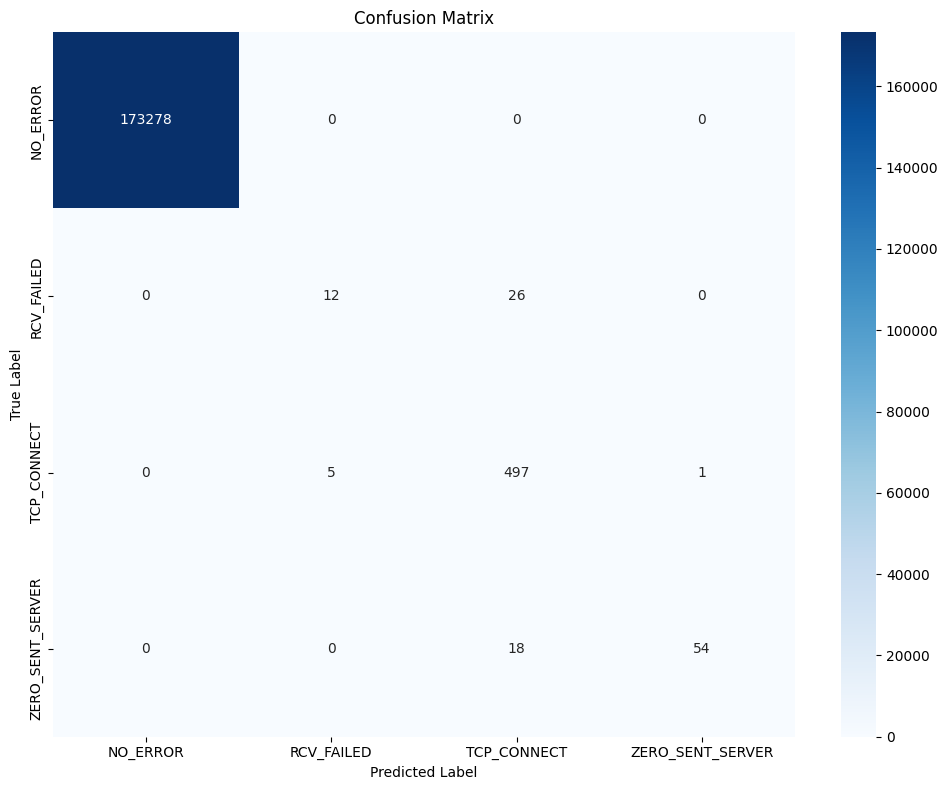

In [35]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_original, y_pred)
class_names = label_encoder.classes_
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
# plt.savefig('confusion_matrix.png')
# print("Confusion matrix saved as 'confusion_matrix.png'")
# plt.close()

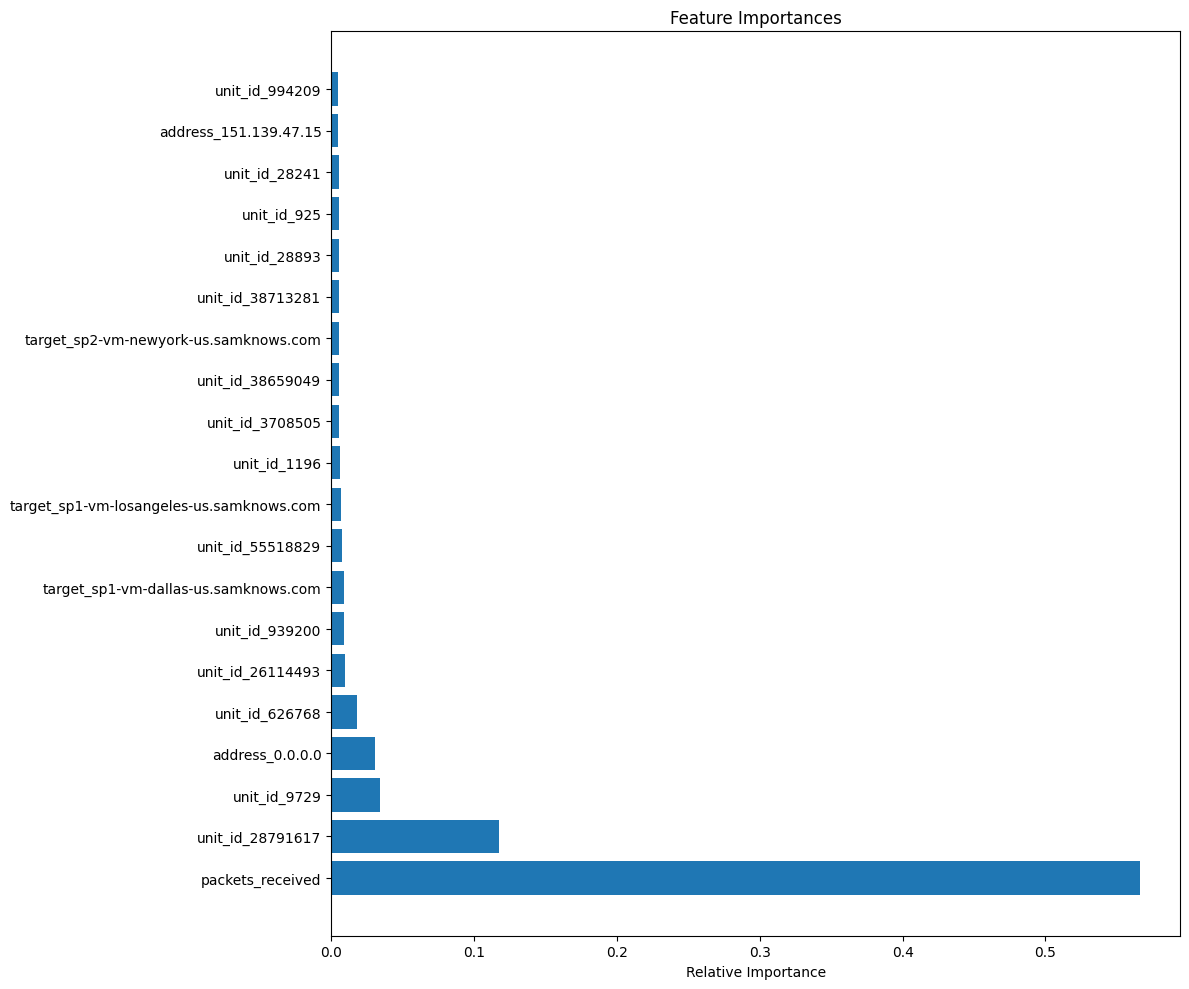

In [36]:
# 9. Feature Importance Analysis
if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
    # Get preprocessor
    preprocessor = pipeline.named_steps['preprocessor']
    
    # Get column transformer output feature names
    feature_names = []
    
    # Add numerical feature names
    feature_names.extend(numerical_features)
    
    # Add one-hot encoded feature names
    ohe = preprocessor.transformers_[1][1]
    if hasattr(ohe, 'get_feature_names_out'):
        # For newer scikit-learn versions
        try:
            cat_feature_names = ohe.get_feature_names_out(categorical_features)
            feature_names.extend(cat_feature_names)
        except:
            # Fallback if above fails
            cat_count = len(pipeline.named_steps['classifier'].feature_importances_) - len(numerical_features)
            cat_feature_names = [f'cat_{i}' for i in range(cat_count)]
            feature_names.extend(cat_feature_names)
    else:
        # For older scikit-learn versions
        try:
            cat_feature_names = ohe.get_feature_names(categorical_features)
            feature_names.extend(cat_feature_names)
        except:
            # Fallback if above fails
            cat_count = len(pipeline.named_steps['classifier'].feature_importances_) - len(numerical_features)
            cat_feature_names = [f'cat_{i}' for i in range(cat_count)]
            feature_names.extend(cat_feature_names)
    
    # Get feature importances
    importances = pipeline.named_steps['classifier'].feature_importances_
    
    # Match feature_names length to importances
    if len(feature_names) > len(importances):
        feature_names = feature_names[:len(importances)]
    elif len(feature_names) < len(importances):
        # Add placeholder names if needed
        feature_names.extend([f'feature_{i}' for i in range(len(feature_names), len(importances))])
    
    # Show top 20 features
    indices = np.argsort(importances)[::-1][:min(20, len(feature_names))]
    
    plt.figure(figsize=(12, 10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    # plt.savefig('feature_importance.png')
    # print("Feature importance plot saved as 'feature_importance.png'")
    # plt.close()

In [38]:
# 10. Save the model and label encoder
import joblib
model_data = {
    'pipeline': pipeline,
    'label_encoder': label_encoder,
    'features': features,
    'label_mapping': label_mapping
}
joblib.dump(model_data, '../data/processed/broadband_error_classifier_xgb.pkl')
print("Model and label encoder saved as 'broadband_error_classifier_xgb.pkl'")


Model and label encoder saved as 'broadband_error_classifier_xgb.pkl'
